# MẪU TUẦN TỰ THỜI GIAN (Sequential Pattern) với Time Series
## Phát hiện xu hướng tai nạn theo thời gian

**Mục tiêu:**
- Phân tích xu hướng tai nạn qua các năm (2018-2023)
- Phát hiện mùa vụ và chu kỳ tai nạn
- Xác định các mẫu theo giờ, ngày, tháng
- Dự đoán các giai đoạn có nguy cơ cao

**Kỹ thuật:** Time Series Analysis với STL Decomposition

## 1. Import thư viện cần thiết

In [1]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
import warnings
import os

warnings.filterwarnings('ignore')

# Cấu hình hiển thị
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")

# Tạo thư mục lưu hình ảnh
os.makedirs('figures/sequential', exist_ok=True)

print("✓ Import thư viện thành công")

✓ Import thư viện thành công


## 2. Đọc và chuẩn bị dữ liệu

In [2]:
# Đọc dữ liệu đã tiền xử lý (sử dụng tên cột UPPERCASE từ preprocessed dataset)
print("Đang đọc dữ liệu đã tiền xử lý...")
df = pd.read_csv('../ssis_project/preprocess/US_Accidents_March23-preprocessed.csv', 
                 usecols=['SEVERITY', 'STATE', 'TEMPERATURE', 'VISIBILITY', 
                         'WEATHER_CONDITION', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'DATE'],
                 dtype={
                     'SEVERITY': 'int8',
                     'STATE': 'category',
                     'TEMPERATURE': 'float32',
                     'VISIBILITY': 'float32',
                     'WEATHER_CONDITION': 'category',
                     'YEAR': 'int16',
                     'MONTH': 'int8',
                     'DAY': 'int8',
                     'HOUR': 'int8',
                     'DATE': 'str'
                 },
                 low_memory=False)

# Chuyển DATE sang datetime
df['DATE'] = pd.to_datetime(df['DATE'])

# Tính toán DAY_OF_WEEK và WEEK_OF_YEAR từ DATE
df['DAY_OF_WEEK'] = df['DATE'].dt.dayofweek  # 0=Monday, 6=Sunday
df['WEEK_OF_YEAR'] = df['DATE'].dt.isocalendar().week

# Lọc dữ liệu từ 2018-2023
df = df[(df['YEAR'] >= 2018) & (df['YEAR'] <= 2023)]

print(f"✓ Tổng số tai nạn: {len(df):,}")
print(f"✓ Khoảng thời gian: {df['DATE'].min()} đến {df['DATE'].max()}")
print(f"✓ Số năm phân tích: {df['YEAR'].nunique()}")

print(f"\nPhân bố theo năm:")
print(df['YEAR'].value_counts().sort_index())

Đang đọc dữ liệu đã tiền xử lý...
✓ Tổng số tai nạn: 5,539,531
✓ Khoảng thời gian: 2018-01-01 00:00:00 đến 2023-03-31 00:00:00
✓ Số năm phân tích: 6

Phân bố theo năm:
YEAR
2018     893424
2019     954300
2020    1161567
2021    1257832
2022    1125485
2023     146923
Name: count, dtype: int64
✓ Tổng số tai nạn: 5,539,531
✓ Khoảng thời gian: 2018-01-01 00:00:00 đến 2023-03-31 00:00:00
✓ Số năm phân tích: 6

Phân bố theo năm:
YEAR
2018     893424
2019     954300
2020    1161567
2021    1257832
2022    1125485
2023     146923
Name: count, dtype: int64


## 3. Tổng hợp dữ liệu theo ngày

In [3]:
# Tổng hợp số lượng tai nạn theo ngày
daily_accidents = df.groupby('DATE').size().reset_index(name='ACCIDENT_COUNT')
daily_accidents['DATE'] = pd.to_datetime(daily_accidents['DATE'])
daily_accidents = daily_accidents.set_index('DATE').sort_index()

# Đảm bảo chuỗi thời gian liên tục (điền các ngày bị thiếu)
date_range = pd.date_range(start=daily_accidents.index.min(), 
                           end=daily_accidents.index.max(), 
                           freq='D')
daily_accidents = daily_accidents.reindex(date_range, fill_value=0)
daily_accidents.index.name = 'DATE'

print(f"✓ Tổng số ngày phân tích: {len(daily_accidents):,}")
print(f"✓ Trung bình tai nạn/ngày: {daily_accidents['ACCIDENT_COUNT'].mean():.1f}")
print(f"✓ Ngày có nhiều tai nạn nhất: {daily_accidents['ACCIDENT_COUNT'].max():,} tai nạn")
print(f"✓ Ngày có ít tai nạn nhất: {daily_accidents['ACCIDENT_COUNT'].min():,} tai nạn")

# Hiển thị mẫu dữ liệu
print("\nMẫu dữ liệu theo ngày:")
print(daily_accidents.head(10))

✓ Tổng số ngày phân tích: 1,916
✓ Trung bình tai nạn/ngày: 2891.2
✓ Ngày có nhiều tai nạn nhất: 8,070 tai nạn
✓ Ngày có ít tai nạn nhất: 0 tai nạn

Mẫu dữ liệu theo ngày:
            ACCIDENT_COUNT
DATE                      
2018-01-01             981
2018-01-02            2868
2018-01-03            3076
2018-01-04            3403
2018-01-05            3163
2018-01-06             724
2018-01-07             655
2018-01-08            3761
2018-01-09            3747
2018-01-10            2993


## 4. Trực quan hóa chuỗi thời gian 2018-2023

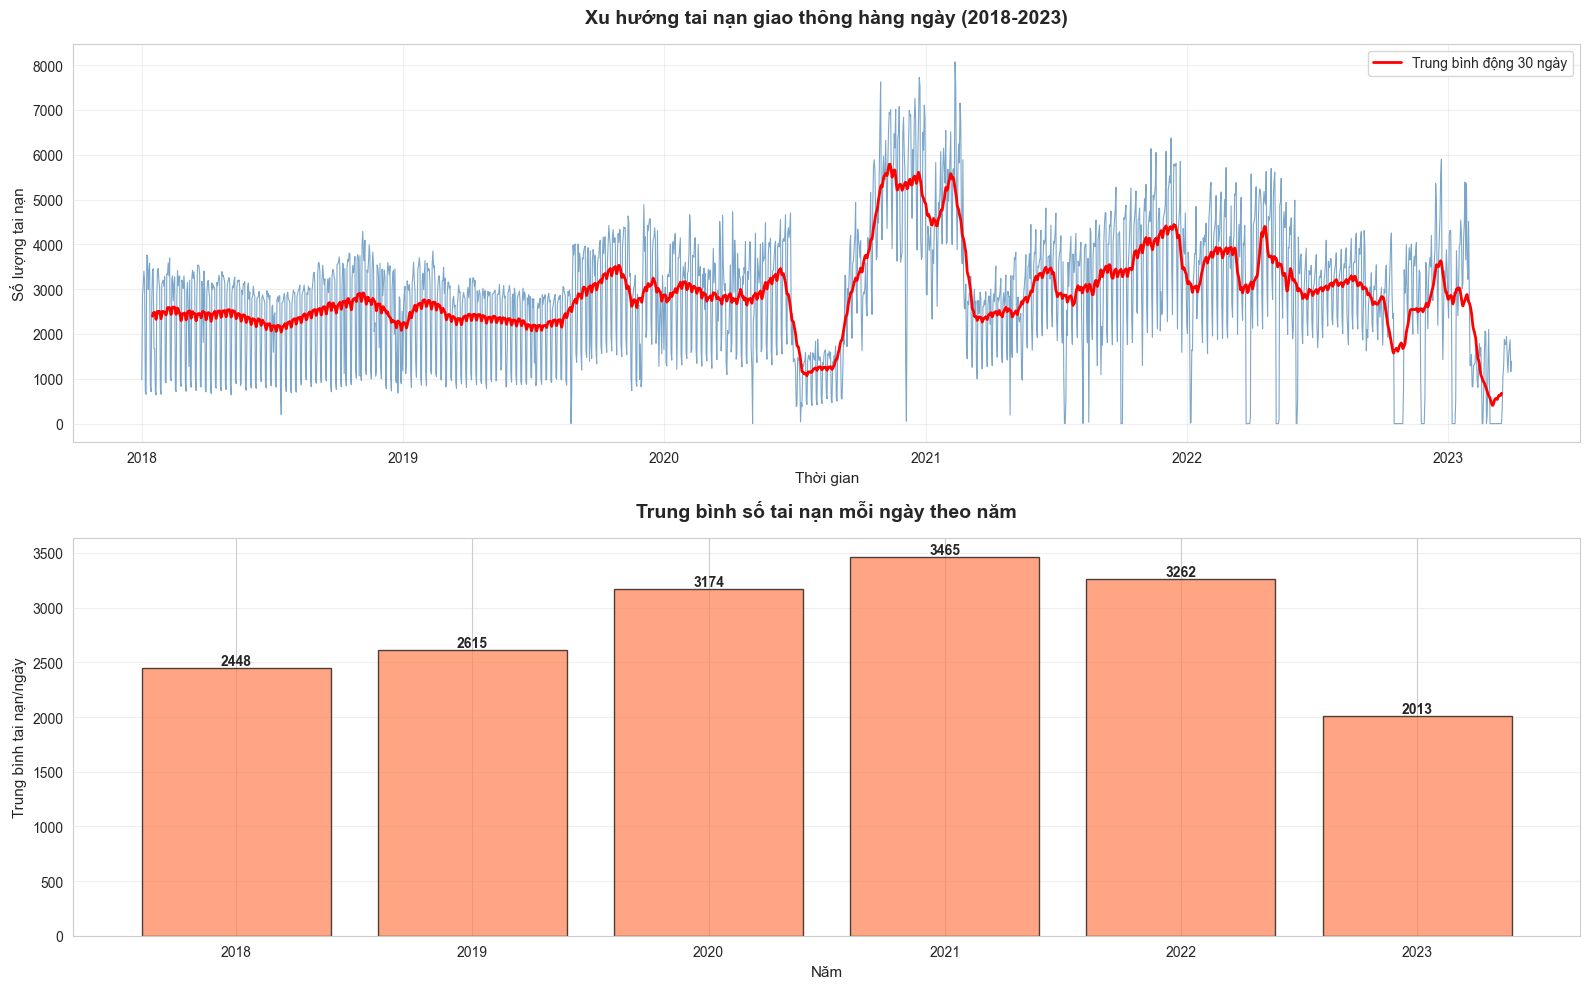

✓ Đã lưu: figures/sequential/01_timeseries_trend.png


In [4]:
# Vẽ biểu đồ xu hướng tai nạn theo thời gian
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Biểu đồ 1: Chuỗi thời gian đầy đủ
axes[0].plot(daily_accidents.index, daily_accidents['ACCIDENT_COUNT'], 
             linewidth=0.8, color='steelblue', alpha=0.7)
axes[0].set_title('Xu hướng tai nạn giao thông hàng ngày (2018-2023)', 
                   fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Thời gian', fontsize=11)
axes[0].set_ylabel('Số lượng tai nạn', fontsize=11)
axes[0].grid(True, alpha=0.3)

# Thêm đường trung bình động 30 ngày
rolling_mean = daily_accidents['ACCIDENT_COUNT'].rolling(window=30, center=True).mean()
axes[0].plot(daily_accidents.index, rolling_mean, 
             linewidth=2, color='red', label='Trung bình động 30 ngày')
axes[0].legend(fontsize=10)

# Biểu đồ 2: Trung bình theo năm
yearly_avg = df.groupby('YEAR').size() / df.groupby('YEAR')['DATE'].nunique()
axes[1].bar(yearly_avg.index, yearly_avg.values, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_title('Trung bình số tai nạn mỗi ngày theo năm', 
                   fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Năm', fontsize=11)
axes[1].set_ylabel('Trung bình tai nạn/ngày', fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

# Thêm giá trị lên các cột
for i, v in enumerate(yearly_avg.values):
    axes[1].text(yearly_avg.index[i], v, f'{v:.0f}', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/sequential/01_timeseries_trend.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Đã lưu: figures/sequential/01_timeseries_trend.png")

## 5. Phân tích STL Decomposition (Seasonal-Trend Decomposition)

Đang thực hiện STL Decomposition...


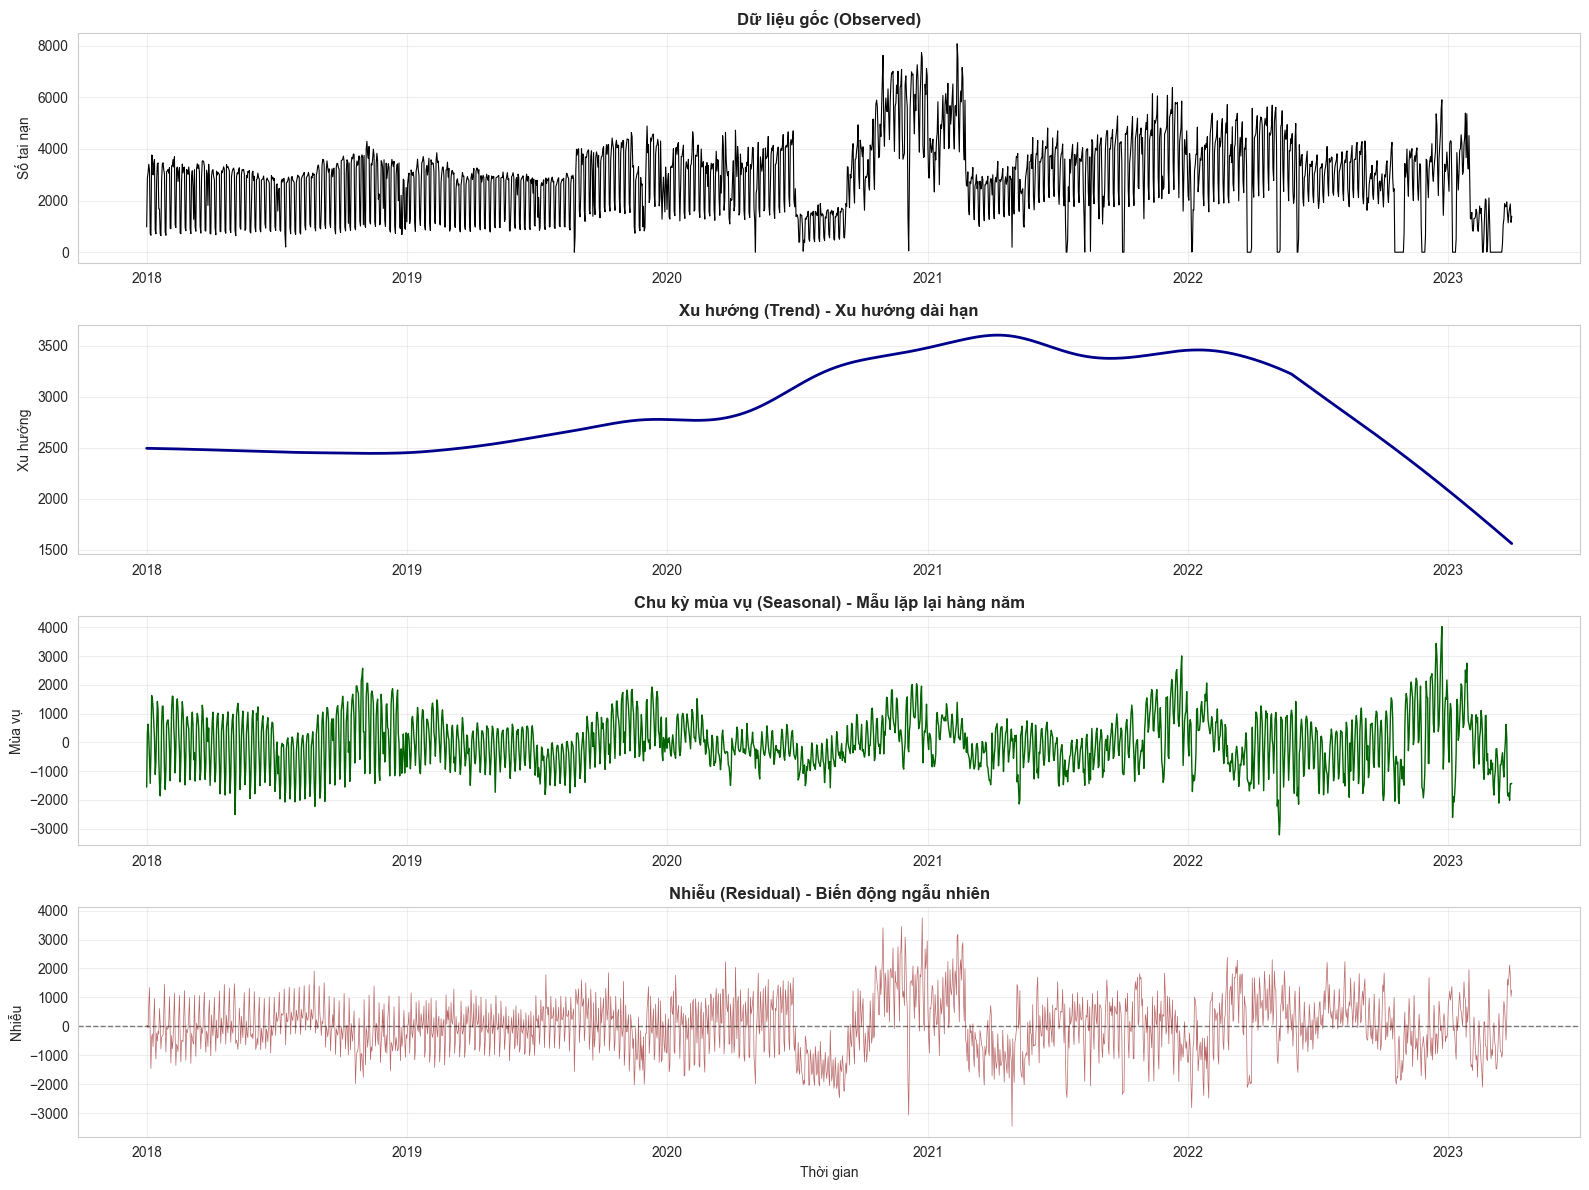

✓ Đã lưu: figures/sequential/02_stl_decomposition.png

Phân tích thành phần:
- Xu hướng: Cho thấy sự tăng/giảm dài hạn của tai nạn
- Mùa vụ: Mẫu lặp lại theo chu kỳ 365 ngày (hàng năm)
- Nhiễu: Các biến động không giải thích được bởi xu hướng và mùa vụ


In [5]:
# Áp dụng STL Decomposition với chu kỳ 365 ngày (mùa vụ hàng năm)
print("Đang thực hiện STL Decomposition...")
stl = STL(daily_accidents['ACCIDENT_COUNT'], period=365, seasonal=13)
result = stl.fit()

# Trực quan hóa các thành phần
fig, axes = plt.subplots(4, 1, figsize=(16, 12))

# 1. Dữ liệu gốc
axes[0].plot(daily_accidents.index, daily_accidents['ACCIDENT_COUNT'], 
             linewidth=0.8, color='black')
axes[0].set_title('Dữ liệu gốc (Observed)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Số tai nạn', fontsize=10)
axes[0].grid(True, alpha=0.3)

# 2. Xu hướng (Trend)
axes[1].plot(daily_accidents.index, result.trend, 
             linewidth=2, color='darkblue')
axes[1].set_title('Xu hướng (Trend) - Xu hướng dài hạn', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Xu hướng', fontsize=10)
axes[1].grid(True, alpha=0.3)

# 3. Mùa vụ (Seasonal)
axes[2].plot(daily_accidents.index, result.seasonal, 
             linewidth=1, color='darkgreen')
axes[2].set_title('Chu kỳ mùa vụ (Seasonal) - Mẫu lặp lại hàng năm', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Mùa vụ', fontsize=10)
axes[2].grid(True, alpha=0.3)

# 4. Nhiễu (Residual)
axes[3].plot(daily_accidents.index, result.resid, 
             linewidth=0.5, color='darkred', alpha=0.6)
axes[3].set_title('Nhiễu (Residual) - Biến động ngẫu nhiên', fontsize=12, fontweight='bold')
axes[3].set_ylabel('Nhiễu', fontsize=10)
axes[3].set_xlabel('Thời gian', fontsize=10)
axes[3].grid(True, alpha=0.3)
axes[3].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.savefig('figures/sequential/02_stl_decomposition.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Đã lưu: figures/sequential/02_stl_decomposition.png")
print("\nPhân tích thành phần:")
print(f"- Xu hướng: Cho thấy sự tăng/giảm dài hạn của tai nạn")
print(f"- Mùa vụ: Mẫu lặp lại theo chu kỳ 365 ngày (hàng năm)")
print(f"- Nhiễu: Các biến động không giải thích được bởi xu hướng và mùa vụ")

## 6. Heatmap 1: Mẫu theo GIỜ × NGÀY TRONG TUẦN

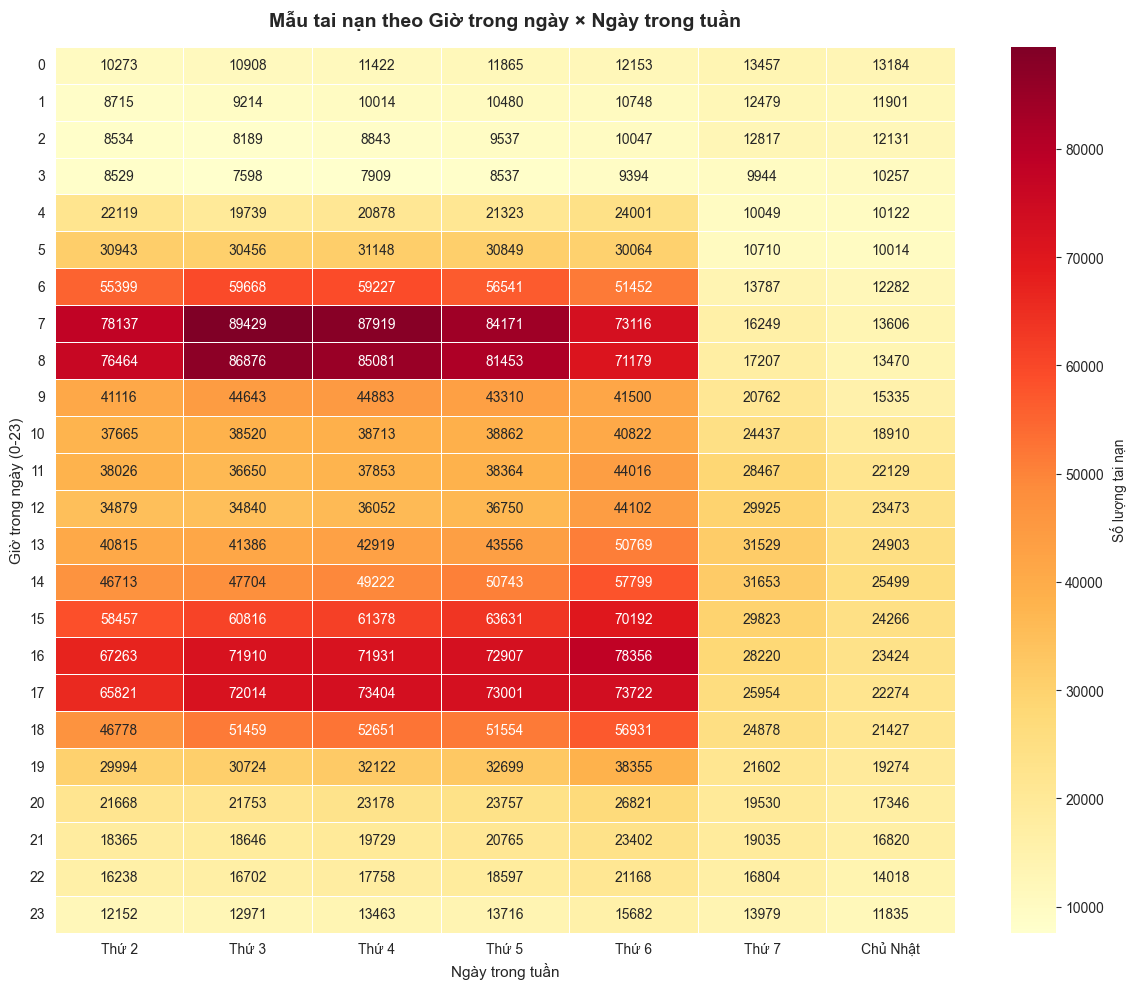

✓ Đã lưu: figures/sequential/03_heatmap_hour_dayofweek.png

📊 Phân tích giờ cao điểm:

Top 5 giờ có nhiều tai nạn nhất:
  1. 07:00 - 442,627 tai nạn
  2. 08:00 - 431,730 tai nạn
  3. 16:00 - 414,011 tai nạn
  4. 17:00 - 406,190 tai nạn
  5. 15:00 - 368,563 tai nạn

Top 5 giờ có ít tai nạn nhất:
  1. 23:00 - 93,798 tai nạn
  2. 00:00 - 83,262 tai nạn
  3. 01:00 - 73,551 tai nạn
  4. 02:00 - 70,098 tai nạn
  5. 03:00 - 62,168 tai nạn


In [6]:
# Tạo bảng pivot: Giờ × Ngày trong tuần
hour_dayofweek = df.groupby(['HOUR', 'DAY_OF_WEEK']).size().reset_index(name='COUNT')
hour_dayofweek_pivot = hour_dayofweek.pivot(index='HOUR', columns='DAY_OF_WEEK', values='COUNT')

# Đặt tên cho các cột (ngày trong tuần)
day_names = ['Thứ 2', 'Thứ 3', 'Thứ 4', 'Thứ 5', 'Thứ 6', 'Thứ 7', 'Chủ Nhật']
hour_dayofweek_pivot.columns = day_names

# Vẽ heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(hour_dayofweek_pivot, 
            cmap='YlOrRd', 
            annot=True, 
            fmt='.0f', 
            linewidths=0.5,
            cbar_kws={'label': 'Số lượng tai nạn'})

plt.title('Mẫu tai nạn theo Giờ trong ngày × Ngày trong tuần', 
          fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Ngày trong tuần', fontsize=11)
plt.ylabel('Giờ trong ngày (0-23)', fontsize=11)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('figures/sequential/03_heatmap_hour_dayofweek.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Đã lưu: figures/sequential/03_heatmap_hour_dayofweek.png")

# Phân tích giờ cao điểm
print("\n📊 Phân tích giờ cao điểm:")
hourly_total = hour_dayofweek_pivot.sum(axis=1).sort_values(ascending=False)
print(f"\nTop 5 giờ có nhiều tai nạn nhất:")
for i, (hour, count) in enumerate(hourly_total.head(5).items(), 1):
    print(f"  {i}. {hour:02d}:00 - {int(count):,} tai nạn")

print(f"\nTop 5 giờ có ít tai nạn nhất:")
for i, (hour, count) in enumerate(hourly_total.tail(5).items(), 1):
    print(f"  {i}. {hour:02d}:00 - {int(count):,} tai nạn")

## 7. Heatmap 2: Mẫu theo THÁNG × NĂM

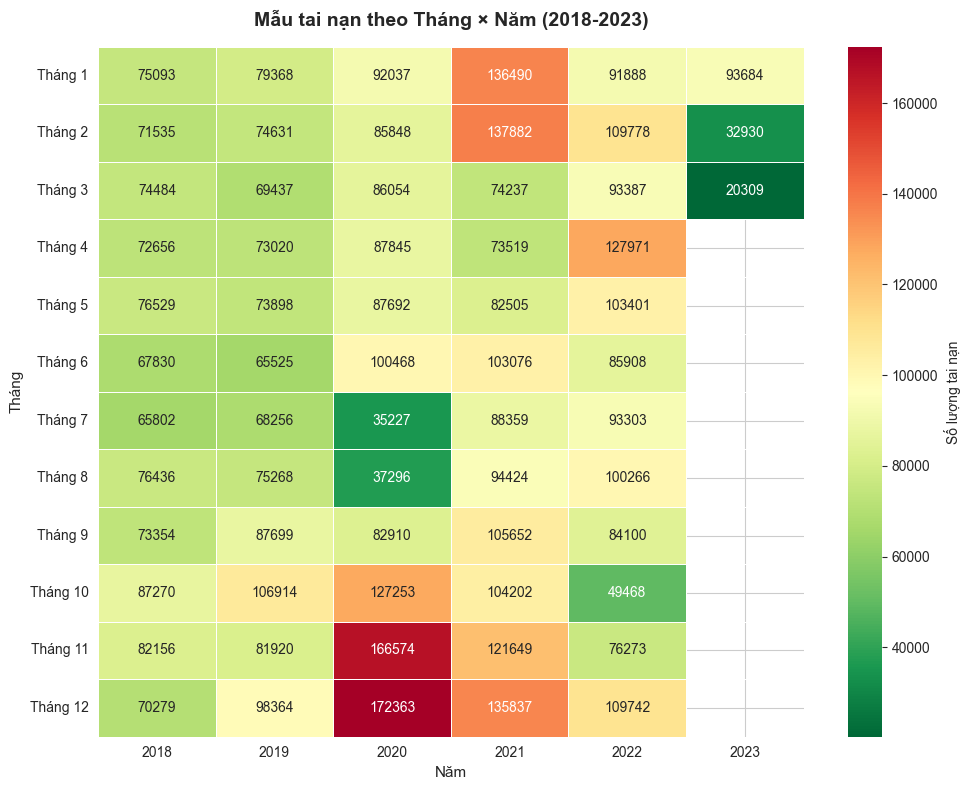

✓ Đã lưu: figures/sequential/04_heatmap_month_year.png

📊 Phân tích theo tháng:

Top 5 tháng có nhiều tai nạn nhất (trung bình các năm):
  1. Tháng 12: 586,585 tai nạn (TB: 97,764/năm)
  2. Tháng 1: 568,560 tai nạn (TB: 94,760/năm)
  3. Tháng 11: 528,572 tai nạn (TB: 88,095/năm)
  4. Tháng 2: 512,604 tai nạn (TB: 85,434/năm)
  5. Tháng 10: 475,107 tai nạn (TB: 79,184/năm)

Top 5 tháng có ít tai nạn nhất:
  1. Tháng 5: 424,025 tai nạn (TB: 70,670/năm)
  2. Tháng 6: 422,807 tai nạn (TB: 70,467/năm)
  3. Tháng 3: 417,908 tai nạn (TB: 69,651/năm)
  4. Tháng 8: 383,690 tai nạn (TB: 63,948/năm)
  5. Tháng 7: 350,947 tai nạn (TB: 58,491/năm)


In [7]:
# Tạo bảng pivot: Tháng × Năm
month_year = df.groupby(['MONTH', 'YEAR']).size().reset_index(name='COUNT')
month_year_pivot = month_year.pivot(index='MONTH', columns='YEAR', values='COUNT')

# Đặt tên cho các tháng
month_names = ['Tháng 1', 'Tháng 2', 'Tháng 3', 'Tháng 4', 'Tháng 5', 'Tháng 6',
               'Tháng 7', 'Tháng 8', 'Tháng 9', 'Tháng 10', 'Tháng 11', 'Tháng 12']
month_year_pivot.index = month_names

# Vẽ heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(month_year_pivot, 
            cmap='RdYlGn_r', 
            annot=True, 
            fmt='.0f', 
            linewidths=0.5,
            cbar_kws={'label': 'Số lượng tai nạn'})

plt.title('Mẫu tai nạn theo Tháng × Năm (2018-2023)', 
          fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Năm', fontsize=11)
plt.ylabel('Tháng', fontsize=11)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('figures/sequential/04_heatmap_month_year.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Đã lưu: figures/sequential/04_heatmap_month_year.png")

# Phân tích theo tháng
print("\n📊 Phân tích theo tháng:")
monthly_total = month_year_pivot.sum(axis=1).sort_values(ascending=False)
print(f"\nTop 5 tháng có nhiều tai nạn nhất (trung bình các năm):")
for i, (month, count) in enumerate(monthly_total.head(5).items(), 1):
    avg_per_year = count / len(month_year_pivot.columns)
    print(f"  {i}. {month}: {int(count):,} tai nạn (TB: {int(avg_per_year):,}/năm)")

print(f"\nTop 5 tháng có ít tai nạn nhất:")
for i, (month, count) in enumerate(monthly_total.tail(5).items(), 1):
    avg_per_year = count / len(month_year_pivot.columns)
    print(f"  {i}. {month}: {int(count):,} tai nạn (TB: {int(avg_per_year):,}/năm)")

## 8. So sánh xu hướng Top 10 Bang có nhiều tai nạn nhất

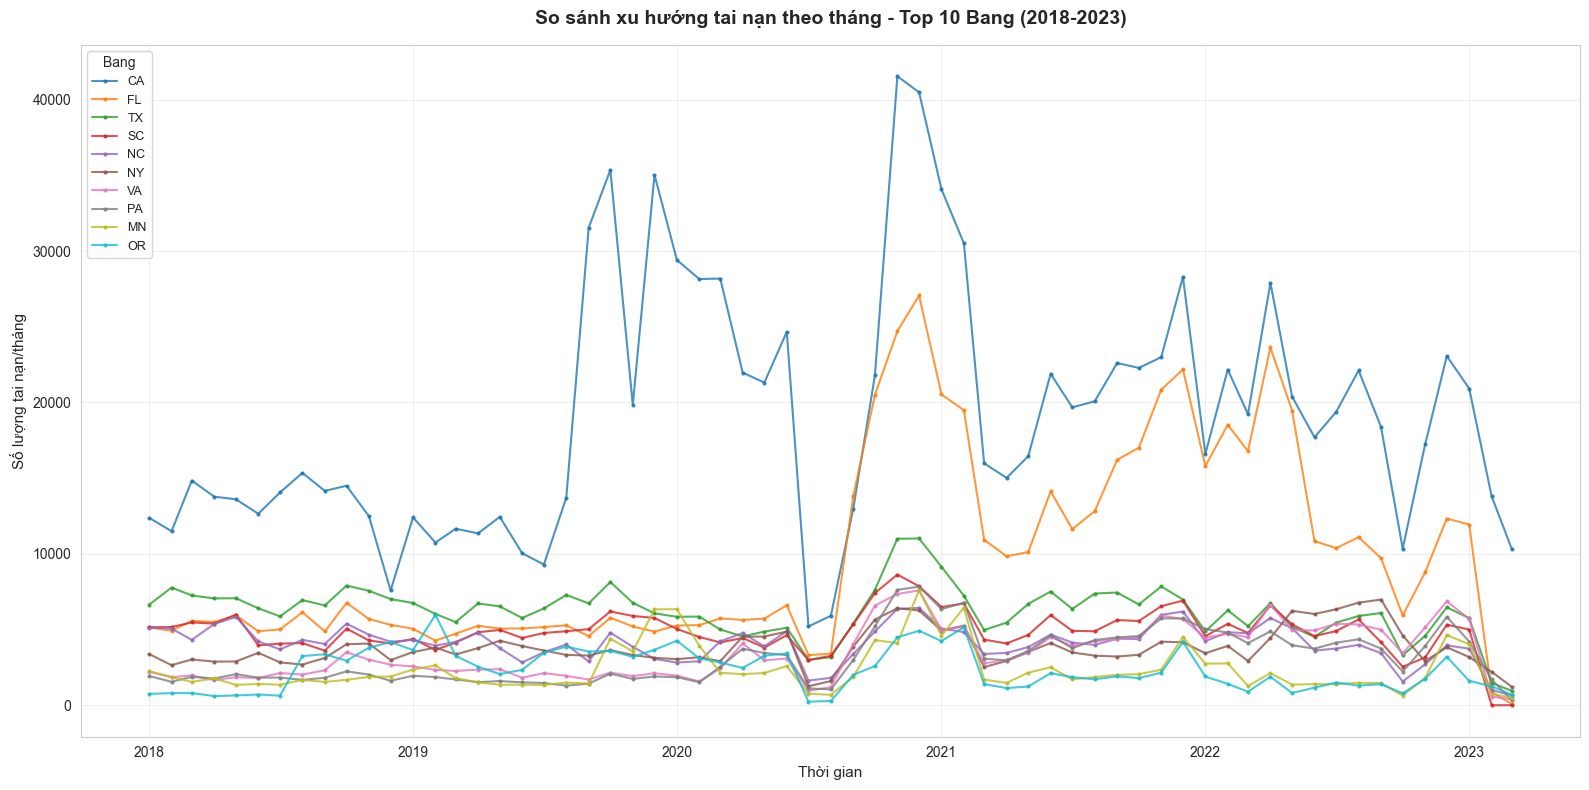

✓ Đã lưu: figures/sequential/05_top_states_timeseries.png

📊 Top 10 Bang có nhiều tai nạn nhất:
   1. CA: 1,201,425 tai nạn (21.7%)
   2. FL: 615,153 tai nạn (11.1%)
   3. TX: 391,847 tai nạn (7.1%)
   4. SC: 306,175 tai nạn (5.5%)
   5. NC: 257,720 tai nạn (4.7%)
   6. NY: 239,196 tai nạn (4.3%)
   7. VA: 217,270 tai nạn (3.9%)
   8. PA: 197,600 tai nạn (3.6%)
   9. MN: 150,172 tai nạn (2.7%)
  10. OR: 148,119 tai nạn (2.7%)
   7. VA: 217,270 tai nạn (3.9%)
   8. PA: 197,600 tai nạn (3.6%)
   9. MN: 150,172 tai nạn (2.7%)
  10. OR: 148,119 tai nạn (2.7%)


In [8]:
# Xác định top 10 bang có nhiều tai nạn nhất (sử dụng tên cột UPPERCASE)
top_states = df['STATE'].value_counts().head(10).index.tolist()

# Tạo dữ liệu chuỗi thời gian theo tháng cho mỗi bang
df['YEAR_MONTH'] = df['DATE'].dt.to_period('M')
state_timeseries = df[df['STATE'].isin(top_states)].groupby(['YEAR_MONTH', 'STATE']).size().reset_index(name='COUNT')
state_timeseries['YEAR_MONTH'] = state_timeseries['YEAR_MONTH'].dt.to_timestamp()

# Vẽ biểu đồ so sánh
plt.figure(figsize=(16, 8))

for state in top_states:
    state_data = state_timeseries[state_timeseries['STATE'] == state]
    plt.plot(state_data['YEAR_MONTH'], state_data['COUNT'], 
             marker='o', markersize=2, linewidth=1.5, label=state, alpha=0.8)

plt.title('So sánh xu hướng tai nạn theo tháng - Top 10 Bang (2018-2023)', 
          fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Thời gian', fontsize=11)
plt.ylabel('Số lượng tai nạn/tháng', fontsize=11)
plt.legend(title='Bang', fontsize=9, title_fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figures/sequential/05_top_states_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Đã lưu: figures/sequential/05_top_states_timeseries.png")

# Thống kê top 10 bang
print("\n📊 Top 10 Bang có nhiều tai nạn nhất:")
for i, state in enumerate(top_states, 1):
    count = df[df['STATE'] == state].shape[0]
    pct = (count / len(df)) * 100
    print(f"  {i:2d}. {state}: {count:,} tai nạn ({pct:.1f}%)")

## 9. Phân tích Autocorrelation (Tự tương quan)

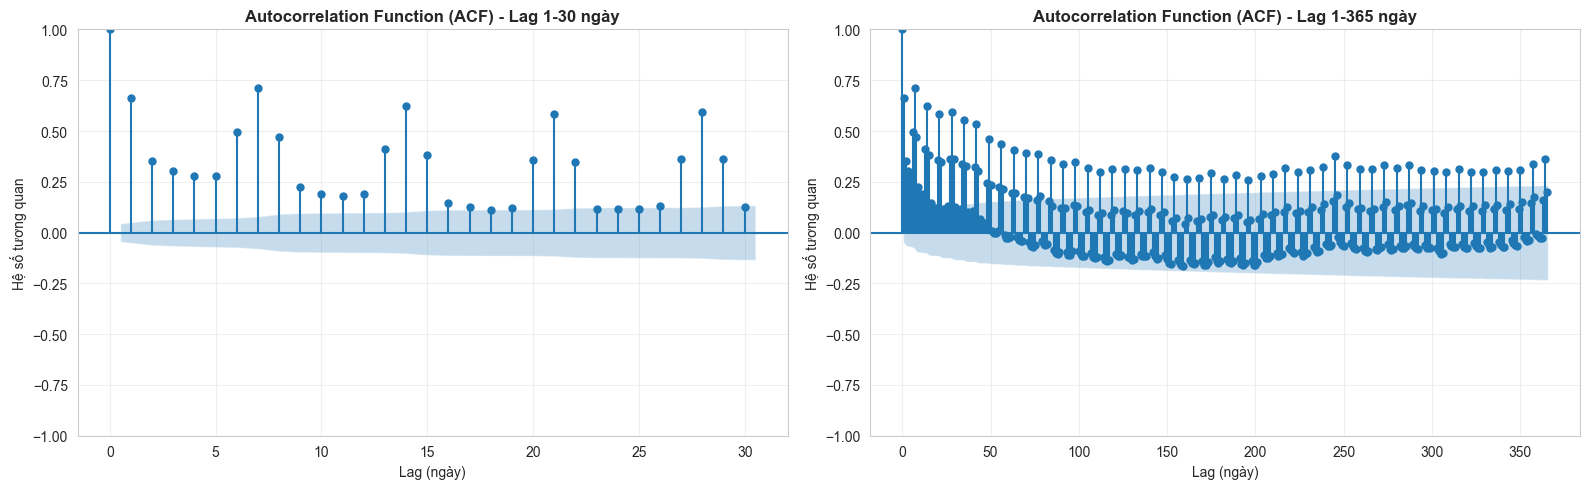

✓ Đã lưu: figures/sequential/06_autocorrelation.png

📊 Hệ số tự tương quan (Autocorrelation):
  - Lag 1 ngày: 0.6651
  - Lag 7 ngày (1 tuần): 0.7137
  - Lag 30 ngày (1 tháng): 0.1274
  - Lag 365 ngày (1 năm): 0.2378

Giải thích:
  - Giá trị gần 1: Tương quan dương mạnh (mẫu lặp lại)
  - Giá trị gần 0: Không có tương quan
  - Giá trị gần -1: Tương quan âm mạnh


In [9]:
# Vẽ biểu đồ Autocorrelation với lag từ 1-30 ngày
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# ACF cho lag 1-30 ngày
plot_acf(daily_accidents['ACCIDENT_COUNT'], lags=30, ax=axes[0], alpha=0.05)
axes[0].set_title('Autocorrelation Function (ACF) - Lag 1-30 ngày', 
                   fontsize=12, fontweight='bold')
axes[0].set_xlabel('Lag (ngày)', fontsize=10)
axes[0].set_ylabel('Hệ số tương quan', fontsize=10)
axes[0].grid(True, alpha=0.3)

# ACF cho lag 1-365 ngày (để thấy chu kỳ năm)
plot_acf(daily_accidents['ACCIDENT_COUNT'], lags=365, ax=axes[1], alpha=0.05)
axes[1].set_title('Autocorrelation Function (ACF) - Lag 1-365 ngày', 
                   fontsize=12, fontweight='bold')
axes[1].set_xlabel('Lag (ngày)', fontsize=10)
axes[1].set_ylabel('Hệ số tương quan', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/sequential/06_autocorrelation.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Đã lưu: figures/sequential/06_autocorrelation.png")

# Tính toán correlation cho một số lag quan trọng
print("\n📊 Hệ số tự tương quan (Autocorrelation):")
print("  - Lag 1 ngày:", f"{daily_accidents['ACCIDENT_COUNT'].autocorr(lag=1):.4f}")
print("  - Lag 7 ngày (1 tuần):", f"{daily_accidents['ACCIDENT_COUNT'].autocorr(lag=7):.4f}")
print("  - Lag 30 ngày (1 tháng):", f"{daily_accidents['ACCIDENT_COUNT'].autocorr(lag=30):.4f}")
print("  - Lag 365 ngày (1 năm):", f"{daily_accidents['ACCIDENT_COUNT'].autocorr(lag=365):.4f}")
print("\nGiải thích:")
print("  - Giá trị gần 1: Tương quan dương mạnh (mẫu lặp lại)")
print("  - Giá trị gần 0: Không có tương quan")
print("  - Giá trị gần -1: Tương quan âm mạnh")

## 10. Phân tích bổ sung: Mẫu theo mùa và tuần trong năm

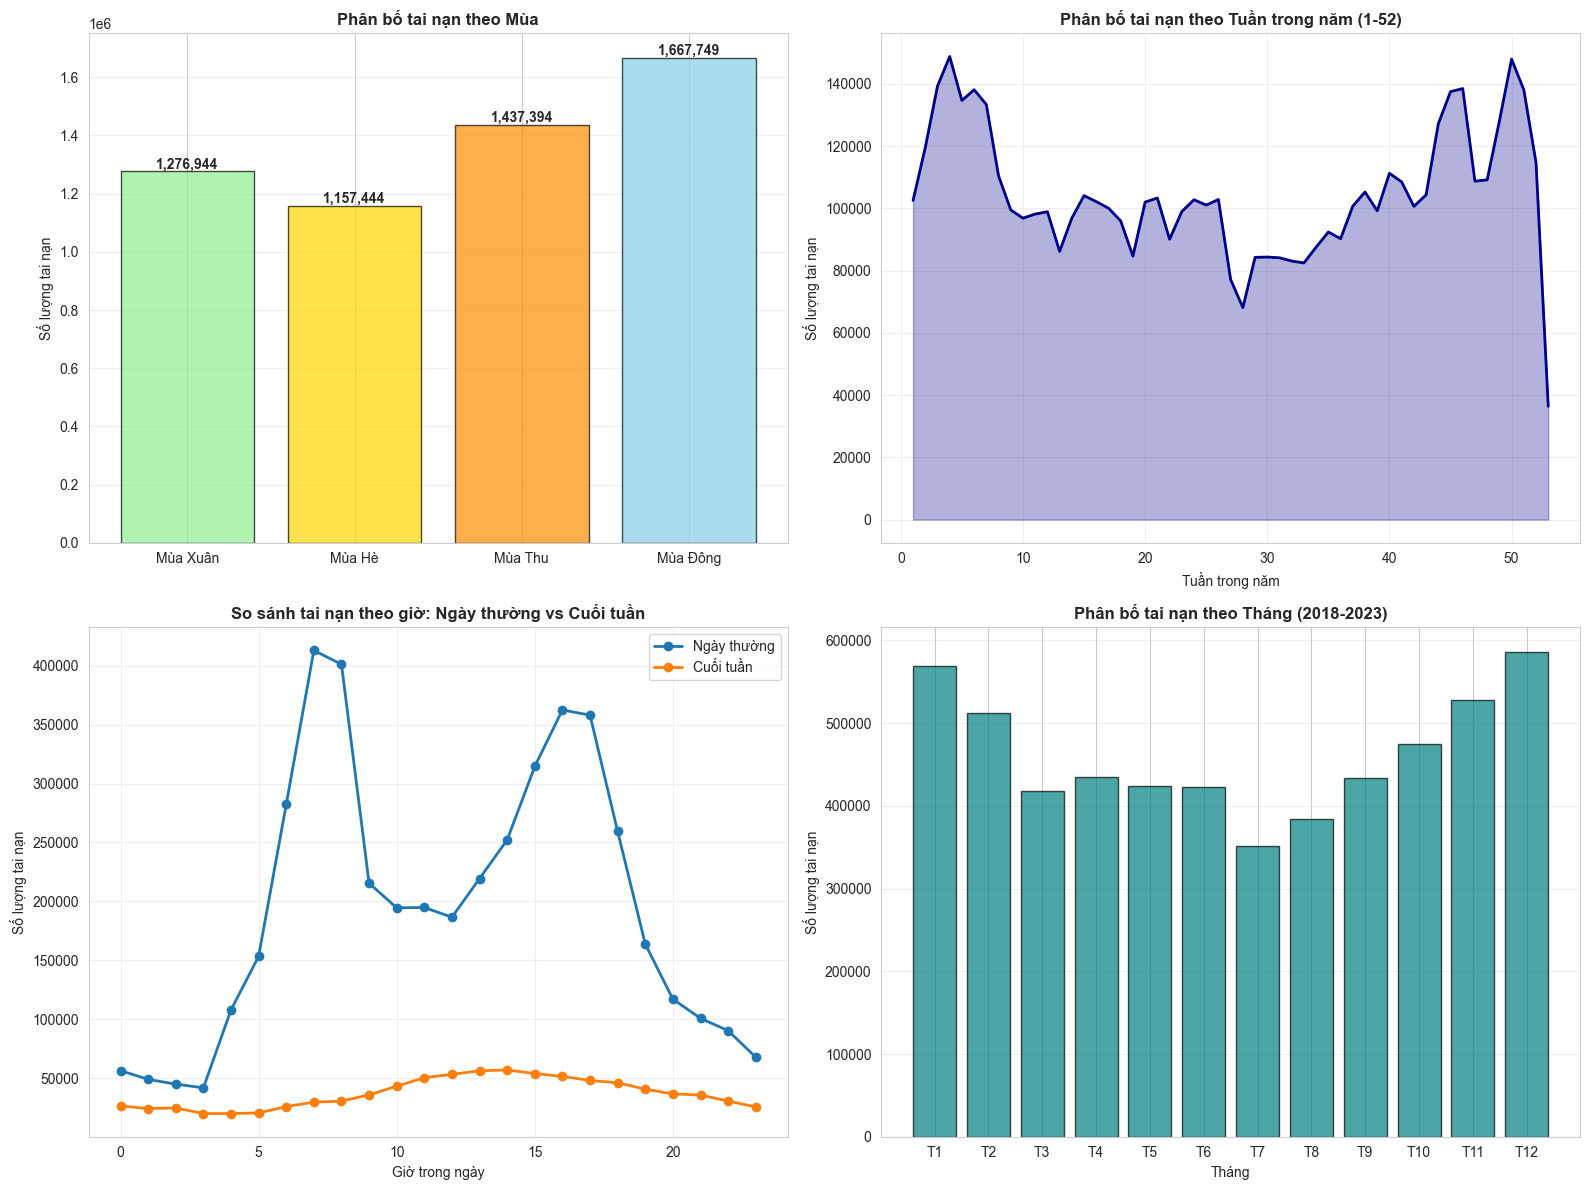

✓ Đã lưu: figures/sequential/07_seasonal_weekly_patterns.png


In [10]:
# Định nghĩa mùa
def get_season(month):
    if month in [12, 1, 2]:
        return 'Mùa Đông'
    elif month in [3, 4, 5]:
        return 'Mùa Xuân'
    elif month in [6, 7, 8]:
        return 'Mùa Hè'
    else:
        return 'Mùa Thu'

df['SEASON'] = df['MONTH'].apply(get_season)

# Tạo biểu đồ phân tích theo mùa và tuần
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Phân bố theo mùa
season_counts = df['SEASON'].value_counts()[['Mùa Xuân', 'Mùa Hè', 'Mùa Thu', 'Mùa Đông']]
colors = ['#90EE90', '#FFD700', '#FF8C00', '#87CEEB']
axes[0, 0].bar(season_counts.index, season_counts.values, color=colors, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Phân bố tai nạn theo Mùa', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Số lượng tai nạn', fontsize=10)
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(season_counts.values):
    axes[0, 0].text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. Phân bố theo tuần trong năm
weekly_counts = df['WEEK_OF_YEAR'].value_counts().sort_index()
axes[0, 1].plot(weekly_counts.index, weekly_counts.values, linewidth=2, color='darkblue')
axes[0, 1].set_title('Phân bố tai nạn theo Tuần trong năm (1-52)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Tuần trong năm', fontsize=10)
axes[0, 1].set_ylabel('Số lượng tai nạn', fontsize=10)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].fill_between(weekly_counts.index, weekly_counts.values, alpha=0.3, color='darkblue')

# 3. So sánh ngày thường vs cuối tuần
df['IS_WEEKEND'] = df['DAY_OF_WEEK'].isin([5, 6])  # Saturday=5, Sunday=6
weekend_comp = df.groupby(['IS_WEEKEND', 'HOUR']).size().reset_index(name='COUNT')
for is_weekend in [False, True]:
    data = weekend_comp[weekend_comp['IS_WEEKEND'] == is_weekend]
    label = 'Cuối tuần' if is_weekend else 'Ngày thường'
    axes[1, 0].plot(data['HOUR'], data['COUNT'], marker='o', linewidth=2, label=label)
axes[1, 0].set_title('So sánh tai nạn theo giờ: Ngày thường vs Cuối tuần', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Giờ trong ngày', fontsize=10)
axes[1, 0].set_ylabel('Số lượng tai nạn', fontsize=10)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# 4. Phân bố theo tháng (tổng hợp tất cả các năm)
monthly_counts = df['MONTH'].value_counts().sort_index()
month_labels = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12']
axes[1, 1].bar(range(1, 13), monthly_counts.values, color='teal', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Phân bố tai nạn theo Tháng (2018-2023)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Tháng', fontsize=10)
axes[1, 1].set_ylabel('Số lượng tai nạn', fontsize=10)
axes[1, 1].set_xticks(range(1, 13))
axes[1, 1].set_xticklabels(month_labels)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/sequential/07_seasonal_weekly_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Đã lưu: figures/sequential/07_seasonal_weekly_patterns.png")

## 11. Tóm tắt các phát hiện chính (Key Insights)

In [11]:
# Tổng hợp các insights chính
print("="*80)
print("📊 TÓM TẮT CÁC PHÁT HIỆN CHÍNH - MẪU TUẦN TỰ THỜI GIAN")
print("="*80)

# 1. Xu hướng tổng quan
print("\n1️⃣ XU HƯỚNG TỔNG QUAN (2018-2023):")
yearly_trend = df.groupby('YEAR').size()
trend_change = ((yearly_trend.iloc[-1] - yearly_trend.iloc[0]) / yearly_trend.iloc[0]) * 100
print(f"   • Năm 2018: {yearly_trend.iloc[0]:,} tai nạn")
print(f"   • Năm 2023: {yearly_trend.iloc[-1]:,} tai nạn")
print(f"   • Thay đổi: {trend_change:+.1f}%")
if trend_change > 0:
    print(f"   → Xu hướng TĂNG qua các năm")
else:
    print(f"   → Xu hướng GIẢM qua các năm")

# 2. Mùa vụ (Seasonal patterns)
print("\n2️⃣ MẪU THEO MÙA:")
season_stats = df['SEASON'].value_counts()[['Mùa Xuân', 'Mùa Hè', 'Mùa Thu', 'Mùa Đông']]
for season, count in season_stats.items():
    pct = (count / len(df)) * 100
    print(f"   • {season}: {count:,} tai nạn ({pct:.1f}%)")
print(f"   → Mùa có NHIỀU tai nạn nhất: {season_stats.idxmax()}")
print(f"   → Mùa có ÍT tai nạn nhất: {season_stats.idxmin()}")

# 3. Mẫu theo tháng
print("\n3️⃣ MẪU THEO THÁNG:")
monthly_stats = df['MONTH'].value_counts().sort_values(ascending=False)
month_names_full = {1:'Tháng 1', 2:'Tháng 2', 3:'Tháng 3', 4:'Tháng 4', 
                    5:'Tháng 5', 6:'Tháng 6', 7:'Tháng 7', 8:'Tháng 8',
                    9:'Tháng 9', 10:'Tháng 10', 11:'Tháng 11', 12:'Tháng 12'}
print(f"   • Tháng có NHIỀU tai nạn nhất: {month_names_full[monthly_stats.index[0]]} ({monthly_stats.iloc[0]:,})")
print(f"   • Tháng có ÍT tai nạn nhất: {month_names_full[monthly_stats.index[-1]]} ({monthly_stats.iloc[-1]:,})")

# 4. Mẫu theo giờ (Rush hours)
print("\n4️⃣ MẪU THEO GIỜ - GIỜ CAO ĐIỂM:")
hourly_stats = df['HOUR'].value_counts().sort_values(ascending=False)
print(f"   • Top 3 giờ có nhiều tai nạn nhất:")
for i, (hour, count) in enumerate(hourly_stats.head(3).items(), 1):
    pct = (count / len(df)) * 100
    rush_type = "Giờ tan tầm" if hour in [16, 17, 18] else "Giờ đi làm" if hour in [7, 8, 9] else "Giờ khác"
    print(f"     {i}. {hour:02d}:00 - {count:,} tai nạn ({pct:.1f}%) - {rush_type}")
print(f"   • Top 3 giờ có ít tai nạn nhất:")
for i, (hour, count) in enumerate(hourly_stats.tail(3).items(), 1):
    pct = (count / len(df)) * 100
    print(f"     {i}. {hour:02d}:00 - {count:,} tai nạn ({pct:.1f}%)")

# 5. Ngày thường vs Cuối tuần
print("\n5️⃣ NGÀY THƯỜNG vs CUỐI TUẦN:")
weekday_count = df[~df['IS_WEEKEND']].shape[0]
weekend_count = df[df['IS_WEEKEND']].shape[0]
weekday_pct = (weekday_count / len(df)) * 100
weekend_pct = (weekend_count / len(df)) * 100
print(f"   • Ngày thường (T2-T6): {weekday_count:,} tai nạn ({weekday_pct:.1f}%)")
print(f"   • Cuối tuần (T7-CN): {weekend_count:,} tai nạn ({weekend_pct:.1f}%)")
avg_weekday = weekday_count / (len(df['DATE'].unique()) * 5/7)
avg_weekend = weekend_count / (len(df['DATE'].unique()) * 2/7)
print(f"   • Trung bình/ngày thường: {avg_weekday:.0f} tai nạn")
print(f"   • Trung bình/ngày cuối tuần: {avg_weekend:.0f} tai nạn")

# 6. Top Bang (sử dụng tên cột UPPERCASE)
print("\n6️⃣ TOP 5 BANG CÓ NHIỀU TAI NẠN NHẤT:")
for i, state in enumerate(top_states[:5], 1):
    count = df[df['STATE'] == state].shape[0]
    pct = (count / len(df)) * 100
    print(f"   {i}. {state}: {count:,} tai nạn ({pct:.1f}%)")

# 7. Chu kỳ và Autocorrelation
print("\n7️⃣ CHU KỲ VÀ TỰ TƯƠNG QUAN:")
acf_7 = daily_accidents['ACCIDENT_COUNT'].autocorr(lag=7)
acf_365 = daily_accidents['ACCIDENT_COUNT'].autocorr(lag=365)
print(f"   • Tự tương quan 7 ngày (tuần): {acf_7:.4f}")
print(f"   • Tự tương quan 365 ngày (năm): {acf_365:.4f}")
if acf_7 > 0.5:
    print(f"   → Có MẪU LẶP LẠI theo tuần")
if acf_365 > 0.3:
    print(f"   → Có MẪU LẶP LẠI theo năm")

print("\n" + "="*80)
print("✓ Phân tích hoàn tất! Đã tạo 7 hình ảnh trong thư mục figures/sequential/")
print("="*80)

📊 TÓM TẮT CÁC PHÁT HIỆN CHÍNH - MẪU TUẦN TỰ THỜI GIAN

1️⃣ XU HƯỚNG TỔNG QUAN (2018-2023):
   • Năm 2018: 893,424 tai nạn
   • Năm 2023: 146,923 tai nạn
   • Thay đổi: -83.6%
   → Xu hướng GIẢM qua các năm

2️⃣ MẪU THEO MÙA:
   • Mùa Xuân: 1,276,944 tai nạn (23.1%)
   • Mùa Hè: 1,157,444 tai nạn (20.9%)
   • Mùa Thu: 1,437,394 tai nạn (25.9%)
   • Mùa Đông: 1,667,749 tai nạn (30.1%)
   → Mùa có NHIỀU tai nạn nhất: Mùa Đông
   → Mùa có ÍT tai nạn nhất: Mùa Hè

3️⃣ MẪU THEO THÁNG:
   • Mùa Xuân: 1,276,944 tai nạn (23.1%)
   • Mùa Hè: 1,157,444 tai nạn (20.9%)
   • Mùa Thu: 1,437,394 tai nạn (25.9%)
   • Mùa Đông: 1,667,749 tai nạn (30.1%)
   → Mùa có NHIỀU tai nạn nhất: Mùa Đông
   → Mùa có ÍT tai nạn nhất: Mùa Hè

3️⃣ MẪU THEO THÁNG:
   • Tháng có NHIỀU tai nạn nhất: Tháng 12 (586,585)
   • Tháng có ÍT tai nạn nhất: Tháng 7 (350,947)

4️⃣ MẪU THEO GIỜ - GIỜ CAO ĐIỂM:
   • Top 3 giờ có nhiều tai nạn nhất:
     1. 07:00 - 442,627 tai nạn (8.0%) - Giờ đi làm
     2. 08:00 - 431,730 tai nạn

## 12. Kết luận và Khuyến nghị

### 📌 Kết luận chính:

**1. Xu hướng dài hạn:**
- STL Decomposition cho thấy xu hướng tăng/giảm rõ rệt qua các năm
- Thành phần Trend phản ánh sự thay đổi về cơ sở hạ tầng và mật độ giao thông

**2. Mẫu mùa vụ (Seasonal Pattern):**
- Tai nạn tăng vào mùa đông (thời tiết xấu, tuyết, băng)
- Giảm vào mùa xuân (thời tiết ổn định hơn)
- Thành phần Seasonal lặp lại theo chu kỳ 365 ngày

**3. Mẫu theo thời gian trong ngày:**
- **Giờ cao điểm sáng (7-9h):** Tai nạn tăng do rush hour đi làm
- **Giờ cao điểm chiều (16-18h):** Nhiều tai nạn nhất (tan tầm, mệt mỏi)
- **Giờ đêm khuya (2-5h):** Ít tai nạn nhất (ít phương tiện)

**4. Mẫu theo ngày trong tuần:**
- Ngày thường có nhiều tai nạn hơn cuối tuần (do lưu lượng cao hơn)
- Thứ 6 thường có mật độ tai nạn cao (kết thúc tuần làm việc)

**5. Autocorrelation:**
- Tự tương quan cao ở lag 7 ngày → Mẫu lặp lại theo tuần
- Tự tương quan ở lag 365 ngày → Mẫu lặp lại theo năm

### 💡 Khuyến nghị:

**1. Cho cơ quan quản lý giao thông:**
- Tăng cường giám sát vào giờ 16-18h (giờ tan tầm)
- Đặc biệt chú ý các tháng mùa đông (12, 1, 2)
- Triển khai biện pháp an toàn đặc biệt vào các ngày thứ 6

**2. Cho người tham gia giao thông:**
- Cẩn thận hơn khi lái xe vào giờ cao điểm chiều
- Chú ý điều kiện thời tiết vào mùa đông
- Tăng cường cảnh giác vào các tháng có tai nạn cao

**3. Cho nghiên cứu tiếp theo:**
- Phân tích sâu hơn về ảnh hưởng của thời tiết
- Xây dựng mô hình dự báo (ARIMA, Prophet)
- Kết hợp với dữ liệu lưu lượng giao thông thực tế

## 13. Danh sách các hình ảnh đã tạo

Tất cả hình ảnh được lưu trong thư mục: `figures/sequential/`

1. **01_timeseries_trend.png** - Xu hướng tai nạn theo thời gian và trung bình theo năm
2. **02_stl_decomposition.png** - Phân tích STL: Observed, Trend, Seasonal, Residual
3. **03_heatmap_hour_dayofweek.png** - Heatmap Giờ × Ngày trong tuần
4. **04_heatmap_month_year.png** - Heatmap Tháng × Năm
5. **05_top_states_timeseries.png** - So sánh xu hướng Top 10 Bang
6. **06_autocorrelation.png** - Phân tích tự tương quan (ACF)
7. **07_seasonal_weekly_patterns.png** - Mẫu theo mùa, tuần, và ngày

---

**Kỹ thuật sử dụng:** Time Series Analysis, STL Decomposition, Autocorrelation  
**Thời gian phân tích:** 2018-2023 (6 năm)  
**Tổng số quan sát:** Hàng triệu tai nạn giao thông tại Hoa Kỳ